### Load Libraries

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

### Load File

In [2]:
header = list(range(1, 17))
header = ["letter"] + header

letter_df_complete = pd.read_csv("letter-recognition.data", 
sep = ",", 
names = header)

### Model

In [3]:
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split

#Prepare dataset
def prepare_dataset(letter, dataset=letter_df_complete, test_prob = 0.2, rand_state = 0):
    #Filter for the letter
    dataset_letter = dataset[dataset["letter"] == letter]

    #Create a copy of the dataset without the letter
    dataset_wo_let = dataset_letter.drop('letter', axis = 1)

    #Split the dataset into training and test data
    letter_train, letter_test = train_test_split(dataset_wo_let, test_size = test_prob, random_state = rand_state)

    return dataset_letter, letter_train, letter_test

#Statistical function to count outliers (https://towardsdatascience.com/use-the-isolated-forest-with-pyod-3818eea68f08)
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

def isolation_forest(train_data, test_data, cont=0.05, max_feat=1.0, max_samp=40, n_est=100, random_state=0):
    #Create a new iForest
    isft = IForest(behaviour='new', contamination=cont, max_features=max_feat, max_samples=max_samp, n_estimators=n_est)
    #'behaviour': 'new',                    for decision function change to match other anomaly detection algorithm API
    #'bootstrap': False,                    bootstrapping applied or not
    #'contamination': 0.1,          % of outliers in dataset
    #'max_features': 1.0,           number of features from X
    #'max_samples': 40,             number of samples to draw (size of a tree)
    #'n_estimators': 100,           number of trees in ensemble
    #'n_jobs': 1,                           parallel jobs to be done
    #'random_state': None,                  random state
    #'verbose': 0                           verbosity of the tree

    #Fit iForest
    isft.fit(train_data)

    #Training data
    y_train_scores = isft.decision_function(train_data)
    y_train_pred = isft.predict(train_data)

    #Test data
    y_test_scores = isft.decision_function(test_data)
    y_test_pred = isft.predict(test_data)

    #Threshold for defined contamination rate
    #print("The threshold for the defined contamination rate:" , isft.threshold_)

    #print("The training data:", count_stat(y_train_pred))
    #print("The testing data:", count_stat(y_test_pred))
    return isft, y_train_scores, y_test_scores

def var_importance(iso_for, let_train):
    isft_vi = iso_for.feature_importances_
    #print(isft_vi)

    for_plot = pd.DataFrame({'x_axis':let_train.columns,
              'y_axis':isft_vi}).sort_values(by='y_axis',ascending=True)
    for_plot['y_axis'].plot.barh()

def plot_train_scores(train_dataset_scores):
    plt.hist(train_dataset_scores, bins='auto') # arguments are passed to np.histogram
    plt.title("Outlier score")
    plt.show()

def descriptive_stat_threshold(df, pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

def full_iso_tree(letter, letter_df_comp=letter_df_complete, cont=0.1, max_feat=1.0, max_samp=40, n_est=100, random_state=0, plot_bool=False):
    #print(letter)
    letter_df, df_train, df_test = prepare_dataset(letter, letter_df_comp)
    isft_letter, df_train_scores, df_test_score = isolation_forest(df_train, df_test, cont=0.1, max_feat=1.0, 
        max_samp=40, n_est=100, random_state=0)
    if plot_bool == True:
        plot_train_scores(df_train_scores)
        var_importance(isft_letter, df_train)
    threshold_df = isft_letter.threshold_ # Or other value from the above histogram
    stat_df = descriptive_stat_threshold(df_train, df_train_scores, threshold_df)
    #print(letter, "\n", descriptive_stat_threshold(df_train, df_train_scores, threshold_df))
    return stat_df

### Test with letters

In [4]:
"""
print("D")
letter_d, d_train, d_test = prepare_dataset(letter_df_complete, "D")
isft_d, d_train_scores, d_test_score = isolation_forest(d_train, d_test)

print("M")
letter_m, m_train, m_test = prepare_dataset(letter_df_complete, "M")
isft_m, m_train_scores, m_test_score = isolation_forest(m_train, m_test)

print("F")
letter_f, f_train, f_test = prepare_dataset(letter_df_complete, "F")
isft_f, f_train_scores, f_test_score = isolation_forest(f_train, f_test)
"""

print("D")
letter_d, d_train, d_test = prepare_dataset("D")
isft_d, d_train_scores, d_test_score = isolation_forest(d_train, d_test)
threshold_df = isft_d.threshold_ # Or other value from the above histogram#
stat_df = descriptive_stat_threshold(d_train, d_train_scores, threshold_df)
print(stat_df)
percentage = stat_df[stat_df['Group'] == 'Outlier']['Count %']
print(percentage)

#full_iso_tree("D", letter_df_complete)

D
     Group  Count    Count %     1      2     3     4     5     6     7     8  \
0   Normal    611  94.875776  3.91   7.01  5.05  5.16  3.87  7.42  6.85  5.99   
1  Outlier     33   5.124224  6.21  10.79  7.18  6.73  5.88  9.52  5.39  4.70   

      9     10    11    12    13    14    15    16  Anomaly_Score  
0  6.56   8.05  5.18  5.67  3.28  7.86  3.80  7.61          -0.08  
1  5.45  10.21  3.85  7.45  5.12  7.30  5.48  8.61           0.02  
1    5.124224
Name: Count %, dtype: float64


### Cross validation

In [21]:
#https://stackoverflow.com/questions/71488625/how-to-create-all-possible-combinations-of-parameters-in-a-dictionaryp


hyper_params = {
    'cont': [0.01, 0.025, 0.05, 0.075, 0.1],
    'max_feat': [1, 8, 16],
    'max_samp': [10, 50, 100],
    'max_est': [10, 25, 50, 100, 250],
    'random_state': [0, 1, 2, 3, 4, 5]
}

def grid_validation(letter, params=hyper_params, letter_df_comp=letter_df_complete):
    a = params.values()
    combinations = list(itertools.product(*a))

    results_df = pd.DataFrame(columns = ['% Outliers', 'Contamination', 'Max Feature', 'Max Sample', 'Max Estimate', 'Random State'])

    for c in combinations:
        stat_df = full_iso_tree(letter, letter_df_comp, cont=c[0], max_feat=c[1], max_samp=c[2], n_est=c[3], random_state=c[4])
        perc_normal = stat_df.loc[stat_df['Group'] == 'Normal', 'Count %'].iloc[0]
        if perc_normal >= 100:
            perc_outlier = 0.000
        else:
            perc_outlier = stat_df.loc[stat_df['Group'] == 'Outlier', 'Count %'].iloc[0]
        results_df = results_df.append({'% Outliers': perc_outlier, 'Contamination': c[0], 'Max Feature': c[1], 
            'Max Sample': c[2], 'Max Estimate': c[3]}, ignore_index = True)

    return results_df

In [14]:
def plot_results(results_df):
    print(results_df.head())
    print(results_df['% Outliers'].describe())

    plt.hist(results_df['% Outliers'])
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(0, 900, 1)
    y = results_df['% Outliers']

    ax.plot(y, color='blue', label='Outliers')

    plt.ylim([9, 11])
    plt.show()

    plt.boxplot(results_df['% Outliers'])
    plt.show()

In [22]:
results_d = grid_validation("D")

In [24]:
results_m = grid_validation("M")

In [25]:
results_f = grid_validation("F")

   % Outliers  Contamination  Max Feature  Max Sample  Max Estimate  \
0        10.0           0.01          1.0        10.0          10.0   
1        10.0           0.01          1.0        10.0          10.0   
2        10.0           0.01          1.0        10.0          10.0   
3        10.0           0.01          1.0        10.0          10.0   
4        10.0           0.01          1.0        10.0          10.0   

   Random State  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
count    1350.000000
mean       10.042533
std         0.126066
min        10.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.806452
Name: % Outliers, dtype: float64


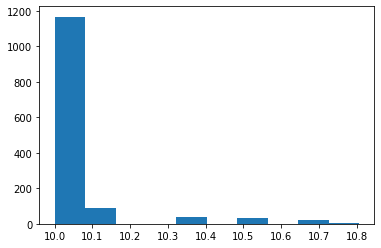

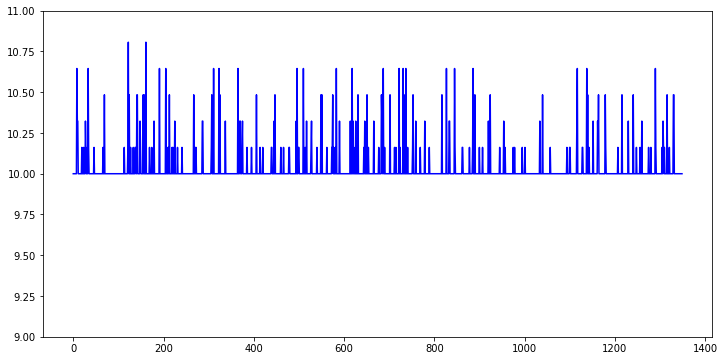

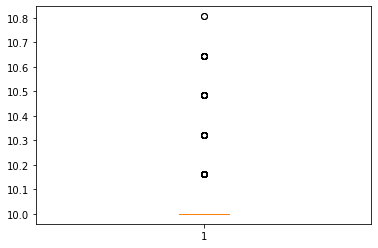

In [28]:
plot_results(results_f)

### Trial

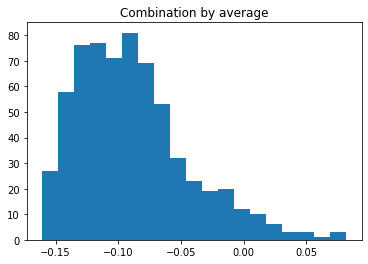

,Group,Count,Count %,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,Anomaly_Score
0,Normal,611,94.875776,3.94,7.09,5.10,5.25,3.97,7.44,6.88,5.98,6.57,8.07,5.18,5.68,3.29,7.83,3.89,7.57,-0.09
1,Outlier,33,5.124224,6.06,10.58,6.73,6.55,5.61,9.24,5.55,4.55,5.45,9.61,3.85,7.36,5.06,7.33,5.94,8.24,0.03


In [19]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.iforest import IForest

letter_d, d_train, d_test = prepare_dataset(letter_df_complete, "D")

# Test a range of the number of trees
k_list = [100, 200, 300, 400, 500]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([d_train.shape[0], n_clf])
test_scores = np.zeros([d_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    #isft = IForest(contamination=0.05, max_samples=k) 
    isft = IForest(contamination=0.05, n_estimators=k) 
    isft.fit(d_train)
    
    # Store the results in each column:
    train_scores[:, i] = isft.decision_function(d_train) 
    test_scores[:, i] = isft.decision_function(d_test) 

# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores)
y_test_by_average = average(test_scores)

plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

descriptive_stat_threshold(d_train,y_train_by_average, 0.00)
